# Mods

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import joblib

import lightgbm as lgb

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

from collections import OrderedDict

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer, recall_score

In [89]:
Df = pd.read_csv("/home/r00323024/loan default/files/loan.csv")

# Data process

In [90]:
df = Df.copy()

In [91]:
# categorize loan status in terms of seriousity
status_map = {
    'Current': 0,
    'Fully Paid': 0,
    'In Grace Period': 0,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 1,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Default': 1
}

df['loan_status'] = df['loan_status'].map(status_map)


In [92]:
# 過濾不能用的變數
cols = [
    'collection_recovery_fee', 'delinq_amnt', 'desc', 'earliest_cr_line', 'emp_title', 
    'funded_amnt', 'funded_amnt_inv', 'id', 'issue_d', 'last_credit_pull_d', 
    'last_pymnt_amnt', 'last_pymnt_d', 'member_id','next_pymnt_d', 'num_tl_30dpd', 'out_prncp', 
    'out_prncp_inv', 'pymnt_plan', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 
    'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp','verification_status_joint','zip_code', 'total_rev_hi_lim', 
    'url', 'sec_app_earliest_cr_line', 
    'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 
    'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 
    'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 
    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 
    'hardship_last_payment_amount', 'disbursement_method', 'debt_settlement_flag', 
    'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 
    'settlement_amount', 'settlement_percentage', 'settlement_term'
]

df.drop(columns=cols, inplace=True)



In [93]:
# encode 類別變數
label_encoder = LabelEncoder()

df['emp_length'] = label_encoder.fit_transform(df['emp_length'])
df['title'] = label_encoder.fit_transform(df['title'])
df['application_type'] = label_encoder.fit_transform(df['application_type'])
df['verification_status'] = label_encoder.fit_transform(df['verification_status'])
df['term'] = label_encoder.fit_transform(df['term']) 
df['home_ownership'] = label_encoder.fit_transform(df['home_ownership']) 
df['sub_grade'] = label_encoder.fit_transform(df['sub_grade'])
df['initial_list_status'] = label_encoder.fit_transform(df['initial_list_status']) 
df['addr_state'] = label_encoder.fit_transform(df['addr_state']) 
df['purpose'] = label_encoder.fit_transform(df['purpose'])

In [94]:
# fill na with mode
emp_length_mode = df['emp_length'].mode()[0]
title_mode = df['title'].mode()[0]


df['emp_length'] = df['emp_length'].fillna(emp_length_mode)
df['title'] = df['title'].fillna(title_mode)


In [95]:
# fill na with median
annual_inc_median = df['annual_inc'].median()
dti_median = df['dti'].median()

df['annual_inc'] = df['annual_inc'].fillna(annual_inc_median)
df['dti'] = df['dti'].fillna(dti_median)

In [96]:
# fill na with 0
for col in df.columns:
    if df[col].isnull().any():
        # print(f"'{col}' : {df[col].dtype}")
        df[col] = df[col].fillna(0)

In [98]:
# combine 主次要申請人資料
mask = df['application_type'] == 1
df.loc[mask, 'annual_inc'] = (df.loc[mask, 'annual_inc'] + df.loc[mask, 'annual_inc_joint']) / 2
df.loc[mask, 'dti'] = (df.loc[mask, 'dti'] + df.loc[mask, 'dti_joint']) / 2
df.loc[mask, 'revol_bal'] = df.loc[mask, 'revol_bal'] + df.loc[mask, 'revol_bal_joint']
df.loc[mask, 'inq_last_6mths'] = df.loc[mask, 'inq_last_6mths'] + df.loc[mask, 'sec_app_inq_last_6mths']
df.loc[mask, 'mort_acc'] = df.loc[mask, 'mort_acc'] + df.loc[mask, 'sec_app_mort_acc']
df.loc[mask, 'open_acc'] = df.loc[mask, 'open_acc'] + df.loc[mask, 'sec_app_open_acc']
df.loc[mask, 'revol_util'] = df.loc[mask, 'revol_util'] + df.loc[mask, 'sec_app_revol_util']
df.loc[mask, 'open_act_il'] = df.loc[mask, 'open_act_il'] + df.loc[mask, 'sec_app_open_act_il']
df.loc[mask, 'num_rev_accts'] = df.loc[mask, 'num_rev_accts'] + df.loc[mask, 'sec_app_num_rev_accts']
df.loc[mask, 'chargeoff_within_12_mths'] = df.loc[mask, 'chargeoff_within_12_mths'] + df.loc[mask, 'sec_app_chargeoff_within_12_mths']
df.loc[mask, 'collections_12_mths_ex_med'] = df.loc[mask, 'collections_12_mths_ex_med'] + df.loc[mask, 'sec_app_collections_12_mths_ex_med']
df.loc[mask, 'mths_since_last_major_derog'] = (df.loc[mask, 'mths_since_last_major_derog'] + df.loc[mask, 'sec_app_mths_since_last_major_derog']) / 2

In [99]:
# def new var
df['installment/annual_inc'] = df['installment'] / df['annual_inc']

df['num_bc_sats/num_bc_tl'] = np.where(df['num_bc_tl'] != 0, df['num_bc_sats'] / df['num_bc_tl'], 0)

df['tot_cur_bal/total_bc_limit'] = np.where(df['total_bc_limit'] != 0, df['tot_cur_bal'] / df['total_bc_limit'], 0)


In [100]:
df = df.drop(columns=[col for col in df.columns if 'joint' in col or 'sec_app' in col])

In [101]:
pd.set_option('display.max_columns', None)
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,installment/annual_inc,num_bc_sats/num_bc_tl,tot_cur_bal/total_bc_limit
0,2500,0,13.56,84.92,C,10,1,5,55000.0,0,0,2,16586,34,18.24,0.0,1.0,0.0,45.0,9.0,1.0,4341,10.3,34.0,1,0.0,0.00,1,0,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,140.0,212.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,0.001544,1.000000,0.463041
1,30000,1,18.94,777.23,D,16,1,1,90000.0,1,0,2,16586,18,26.52,0.0,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,1,0.0,0.00,1,0,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,163.0,378.0,4.0,3.0,3.0,4.0,0.0,4.0,0.0,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,0.008636,0.444444,21.461000
2,5000,0,17.97,180.69,D,15,6,1,59280.0,1,0,2,16586,22,10.51,0.0,0.0,0.0,0.0,8.0,0.0,4599,19.1,13.0,1,0.0,0.00,1,0,0.0,0.0,110299.0,0.0,1.0,0.0,2.0,14.0,7150.0,72.0,0.0,2.0,0.0,35.0,1.0,5.0,0.0,4.0,18383.0,13800.0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,0.0,14.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0,6.0,7.0,3.0,8.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,0.003048,1.000000,7.992681
3,4000,0,18.94,146.51,D,16,1,1,92000.0,1,0,2,16586,47,16.74,0.0,0.0,0.0,0.0,10.0,0.0,5468,78.1,13.0,1,0.0,0.00,1,0,0.0,686.0,305049.0,1.0,5.0,3.0,5.0,5.0,30683.0,68.0,0.0,0.0,3761.0,70.0,2.0,4.0,3.0,5.0,30505.0,1239.0,75.2,0.0,62.0,154.0,64.0,5.0,3.0,64.0,0.0,5.0,0.0,0.0,1.0,2.0,1.0,2.0,7.0,2.0,3.0,2.0,10.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,0.001592,0.500000,61.009800
4,30000,1,16.14,731.78,C,13,1,1,57250.0,0,0,2,16586,20,26.35,0.0,0.0,0.0,0.0,12.0,0.0,829,3.6,26.0,1,0.0,0.00,1,0,0.0,0.0,116007.0,3.0,5.0,3.0,5.0,4.0,28845.0,89.0,2.0,4.0,516.0,54.0,1.0,0.0,0.0,9.0,9667.0,8471.0,8.9,0.0,53.0,216.0,2.0,2.0,2.0,2.0,0.0,13.0,0.0,0.0,2.0,2.0,3.0,8.0,9.0,6.0,15.0,2.0,12.0,0.0,0.0,5.0,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,0.012782,0.375000,12.473871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,12000,1,14.08,279.72,C,12,1,1,58000.0,0,0,2,16586,46,20.88,0.0,0.0,0.0,0.0,12.0,0.0,9592,39.2,34.0,1,0.0,0.00,1,0,0.0,7921.0,45212.0,2.0,2.0,0.0,1.0,24.0,35620.0,36.0,3.0,4.0,4052.0,38.0,2.0,2.0,1.0,5.0,4110.0,1807.0,70.9,0.0,157.0,164.0,1.0,1.0,2.0,9.0,0.0,9.0,0.0,0.0,2.0,4.0,3.0,9.0,11.0,10.0,21.0,4.0,12.0,0.0,0.0,3.0,100.0,66.7,0.0,0.0,73948.0,45212.0,6200.0,49448.0,0.004823,0.333333,7.292258
2260664,12000

# Tune RF,lightGBM for grade == G

In [14]:
X = df[df["grade"] == 'G']

y = X['loan_status']

X = X.drop(['loan_status','grade'], axis=1)

Random_State = 1

rus = RandomOverSampler(random_state = Random_State )
X, y = rus.fit_resample(X, y)


In [16]:
# RF 針對最低recall rate調參

def custom_recall_scorer(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

scorer = make_scorer(custom_recall_scorer)

param_dist = {
    'n_estimators': np.arange(50, 151, 25),
    'max_features': ['auto', 'sqrt', 70],
    'max_depth': [None] + list(np.arange(30, 151, 10)),
    'min_samples_split': np.arange(5, 11),
    'min_samples_leaf': np.arange(2, 11),
    'bootstrap': [True]  
}


rf = RandomForestClassifier(oob_score=True, random_state=Random_State)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  
    scoring=scorer,  
    cv=5,  
    random_state=Random_State,
    n_jobs=-1  
)
random_search.fit(X, y)
print("Best parameters found: ", random_search.best_params_)




best_rf = random_search.best_estimator_
best_rf.fit(X, y)

oob_predictions = np.argmax(best_rf.oob_decision_function_, axis=1)
oob_recall = recall_score(y, oob_predictions, pos_label=1)
print(f"OOB Recall Rate for class 1: {oob_recall:.4f}")

print(classification_report(y, oob_predictions))


Best parameters found:  {'n_estimators': 125, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 70, 'max_depth': 30, 'bootstrap': True}
OOB Recall Rate for class 1: 0.7597
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      7358
           1       0.74      0.76      0.75      7358

    accuracy                           0.75     14716
   macro avg       0.75      0.75      0.75     14716
weighted avg       0.75      0.75      0.75     14716



In [ ]:
# 儲存訓練好的模型
# joblib.dump(best_rf, '/home/r00323024/loan default/files/RF_grade_G.joblib')

In [62]:
# Rank feature importance and draw confusion matrix
importances = best_rf.feature_importances_
feature_names = X.columns


feature_importances = list(zip(feature_names, importances))
feature_importances.sort(key=lambda x: x[1], reverse=True)


top_features = feature_importances[:25]
top_feature_names = [x[0] for x in top_features]
top_feature_importances = [x[1] for x in top_features]


oob_predictions = best_rf.oob_decision_function_
predicted_classes = oob_predictions.argmax(axis=1) 
cm = confusion_matrix(y, predicted_classes)

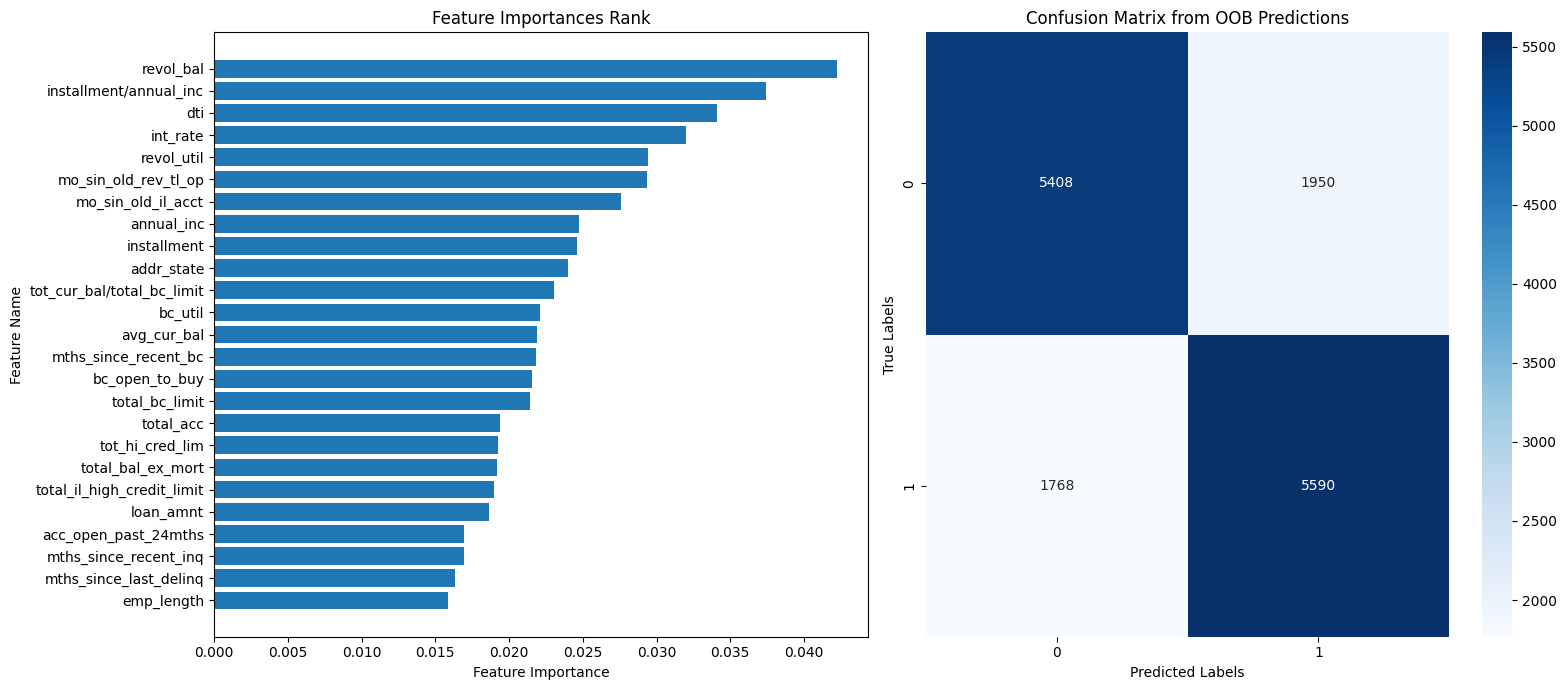

In [67]:
# Rank feature importance and draw confusion matrix
plt.figure(figsize=(16, 7))

# Plot feature importances
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.barh(top_feature_names, top_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances Rank')
plt.gca().invert_yaxis()

# Plot confusion matrix
plt.subplot(1, 2, 2)  
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix from OOB Predictions')

plt.tight_layout()  


In [ ]:
# lightGBM 針對最低recall rate調參

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=Random_State)

param_dist = {
    'num_leaves': np.arange(50, 101, 25),
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'n_estimators': np.arange(100, 301, 25),
}

lgb_clf = lgb.LGBMClassifier()


random_search = RandomizedSearchCV(lgb_clf, param_distributions=param_dist, scoring='recall', cv=5, n_iter=10, verbose=0)
random_search.fit(X_train, y_train)


best_params = random_search.best_params_


best_lgb_clf = lgb.LGBMClassifier(**best_params)
best_lgb_clf.fit(X_train, y_train)

y_pred = best_lgb_clf.predict(X_test)

report = classification_report(y_test, y_pred)


In [78]:
joblib.dump(best_lgb_clf, '/home/r00323024/loan default/files/lgb_clf_grade_G.joblib')

['/home/r00323024/loan default/files/lgb_clf_grade_G.joblib']

Best parameters found:  {'num_leaves': 50, 'n_estimators': 150, 'learning_rate': 0.25}
              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1517
           1       0.68      0.75      0.71      1427

    accuracy                           0.71      2944
   macro avg       0.71      0.71      0.71      2944
weighted avg       0.71      0.71      0.71      2944



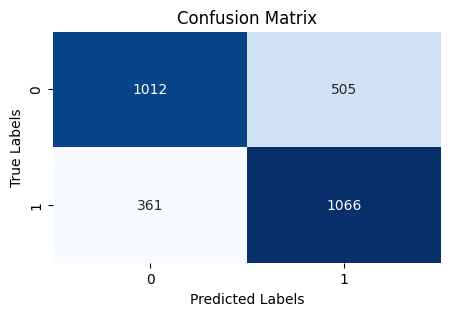

In [79]:
# Print accuracy score
print("Best parameters found: ", best_params)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

print(report)

# model for grade == F

In [103]:
X = df[df["grade"] == 'F']

y = X['loan_status']

X = X.drop(['loan_status','grade'], axis=1)

Random_State = 1

rus = RandomOverSampler(random_state = Random_State )
X, y = rus.fit_resample(X, y)


In [104]:
# RF 針對最低recall rate調參

def custom_recall_scorer(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

scorer = make_scorer(custom_recall_scorer)

param_dist = {
    'n_estimators': np.arange(75, 201, 25),
    'max_features': ['auto', 'sqrt', 70],
    'max_depth': [None] + list(np.arange(30, 71, 10)),
    'min_samples_split': np.arange(5, 11),
    'min_samples_leaf': np.arange(2, 11),
    'bootstrap': [True]  
}


rf = RandomForestClassifier(oob_score=True, random_state=Random_State)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  
    scoring=scorer,  
    cv=5,  
    random_state=Random_State,
    n_jobs=-1  
)
random_search.fit(X, y)
print("Best parameters found: ", random_search.best_params_)




best_rf = random_search.best_estimator_
best_rf.fit(X, y)

oob_predictions = np.argmax(best_rf.oob_decision_function_, axis=1)
oob_recall = recall_score(y, oob_predictions, pos_label=1)
print(f"OOB Recall Rate for class 1: {oob_recall:.4f}")

print(classification_report(y, oob_predictions))


Best parameters found:  {'n_estimators': 75, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 70, 'max_depth': 40, 'bootstrap': True}
OOB Recall Rate for class 1: 0.8241
              precision    recall  f1-score   support

           0       0.81      0.76      0.78     26724
           1       0.77      0.82      0.80     26724

    accuracy                           0.79     53448
   macro avg       0.79      0.79      0.79     53448
weighted avg       0.79      0.79      0.79     53448



In [105]:
# 儲存訓練好的模型
joblib.dump(best_rf, '/home/r00323024/loan default/files/RF_grade_F.joblib')

['/home/r00323024/loan default/files/RF_grade_F.joblib']

In [106]:
# Rank feature importance and draw confusion matrix
importances = best_rf.feature_importances_
feature_names = X.columns


feature_importances = list(zip(feature_names, importances))
feature_importances.sort(key=lambda x: x[1], reverse=True)


top_features = feature_importances[:25]
top_feature_names = [x[0] for x in top_features]
top_feature_importances = [x[1] for x in top_features]


oob_predictions = best_rf.oob_decision_function_
predicted_classes = oob_predictions.argmax(axis=1) 
cm = confusion_matrix(y, predicted_classes)

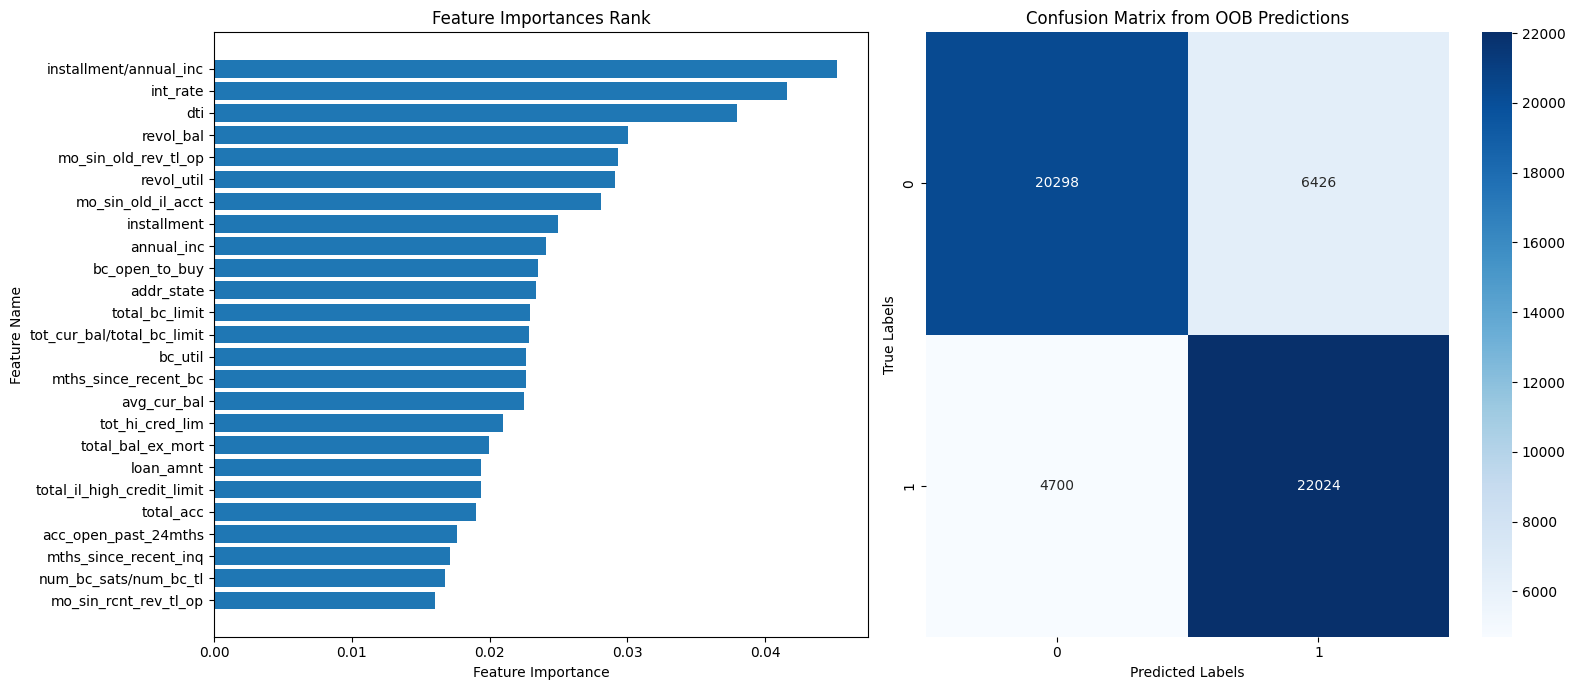

In [107]:
# Rank feature importance and draw confusion matrix
plt.figure(figsize=(16, 7))

# Plot feature importances
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.barh(top_feature_names, top_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances Rank')
plt.gca().invert_yaxis()

# Plot confusion matrix
plt.subplot(1, 2, 2)  
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix from OOB Predictions')

plt.tight_layout()  


In [108]:
# lightGBM 針對最低recall rate調參

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=Random_State)

param_dist = {
    'num_leaves': np.arange(50, 101, 25),
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'n_estimators': np.arange(100, 301, 25),
}

lgb_clf = lgb.LGBMClassifier()


random_search = RandomizedSearchCV(lgb_clf, param_distributions=param_dist, scoring='recall', cv=5, n_iter=10, verbose=0)
random_search.fit(X_train, y_train)


best_params = random_search.best_params_


best_lgb_clf = lgb.LGBMClassifier(**best_params)
best_lgb_clf.fit(X_train, y_train)

y_pred = best_lgb_clf.predict(X_test)

report = classification_report(y_test, y_pred)


[LightGBM] [Info] Number of positive: 17042, number of negative: 17164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8658
[LightGBM] [Info] Number of data points in the train set: 34206, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498217 -> initscore=-0.007133
[LightGBM] [Info] Start training from score -0.007133
[LightGBM] [Info] Number of positive: 17041, number of negative: 17165
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8664
[LightGBM] [Info] Number of data points in the train set: 34206, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498187 -> initscore=-0.007250
[LightGBM] [Info] Start training from score -0.007250
[LightGBM] [

In [109]:
joblib.dump(best_lgb_clf, '/home/r00323024/loan default/files/lgb_clf_grade_F.joblib')

['/home/r00323024/loan default/files/lgb_clf_grade_F.joblib']

Best parameters found:  {'num_leaves': 50, 'n_estimators': 275, 'learning_rate': 0.25}
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      5268
           1       0.72      0.78      0.75      5422

    accuracy                           0.73     10690
   macro avg       0.73      0.73      0.73     10690
weighted avg       0.73      0.73      0.73     10690



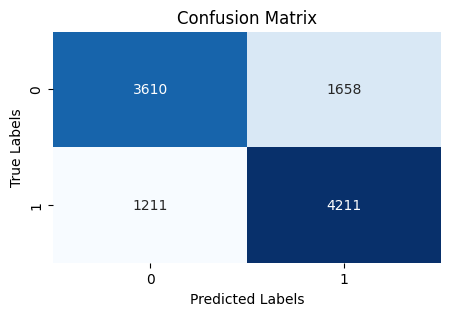

In [110]:
# Print accuracy score
print("Best parameters found: ", best_params)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

print(report)

# DEMO : USE RF to predict

In [36]:
# 導出要輸入的資料的範本

selected_row = Df[(Df['grade'] == 'G') & (Df['application_type'] == 'Joint App')].sample(n=1)

selected_row.to_excel('/home/r00323024/loan default/files/demo.xlsx', index=False)

# open xlsx file and fill in your info

In [54]:
testdf = pd.read_excel('/home/r00323024/loan default/files/demo.xlsx')

In [43]:
testdf

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,24050,24050,24050,60 months,30.79,789.81,G,G1,Fire Marshal,10+ years,MORTGAGE,68238,Verified,May-2017,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,275xx,NC,51.1,0,Apr-2006,0,NaN,NaN,17,0,20168,72.3,27,f,19325.75,19325.75,16582.7,16582.7,4724.25,11858.45,0,0,0,Feb-2019,789.81,Mar-2019,Feb-2019,0,NaN,1,Joint App,122448,31.77,Verified,0,0,96434,0,5,1,2,12,71884,62,0,0,5603,65,27900,4,1,4,2,6027,7057,65.9,0,0,107,133,26,12,0,26,NaN,8,NaN,0,5,7,6,7,13,9,13,7,17,0,0,0,1,100,16.7,0,0,148303,96434,20700,115993,71500,Oct-2004,0,0,6,90.1,2,4,0,0,16,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:

# categorize loan status in terms of seriousity
status_map = {
    'Current': 0,
    'Fully Paid': 0,
    'In Grace Period': 0,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 1,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Default': 1
}

testdf['loan_status'] = testdf['loan_status'].map(status_map)

# 過濾不能用的變數
cols = [
    'collection_recovery_fee', 'delinq_amnt', 'desc', 'earliest_cr_line', 'emp_title', 
    'funded_amnt', 'funded_amnt_inv', 'id', 'issue_d', 'last_credit_pull_d', 
    'last_pymnt_amnt', 'last_pymnt_d', 'member_id','next_pymnt_d', 'num_tl_30dpd', 'out_prncp', 
    'out_prncp_inv', 'pymnt_plan', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 
    'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp','verification_status_joint','zip_code', 'total_rev_hi_lim', 
    'url', 'sec_app_earliest_cr_line', 
    'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 
    'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 
    'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 
    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 
    'hardship_last_payment_amount', 'disbursement_method', 'debt_settlement_flag', 
    'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 
    'settlement_amount', 'settlement_percentage', 'settlement_term'
]

testdf.drop(columns=cols, inplace=True)



# encode 类别变量
label_encoder = LabelEncoder()

testdf['emp_length'] = label_encoder.fit_transform(testdf['emp_length'])
testdf['title'] = label_encoder.fit_transform(testdf['title'])
testdf['application_type'] = label_encoder.fit_transform(testdf['application_type'])
testdf['verification_status'] = label_encoder.fit_transform(testdf['verification_status'])
testdf['term'] = label_encoder.fit_transform(testdf['term']) 
testdf['home_ownership'] = label_encoder.fit_transform(testdf['home_ownership']) 
testdf['sub_grade'] = label_encoder.fit_transform(testdf['sub_grade'])
testdf['initial_list_status'] = label_encoder.fit_transform(testdf['initial_list_status']) 
testdf['addr_state'] = label_encoder.fit_transform(testdf['addr_state']) 
testdf['purpose'] = label_encoder.fit_transform(testdf['purpose'])

# fill na with mode
emp_length_mode = testdf['emp_length'].mode()[0]
title_mode = testdf['title'].mode()[0]


testdf['emp_length'] = testdf['emp_length'].fillna(emp_length_mode)
testdf['title'] = testdf['title'].fillna(title_mode)


# fill na with median
annual_inc_median = testdf['annual_inc'].median()
dti_median = testdf['dti'].median()

testdf['annual_inc'] = testdf['annual_inc'].fillna(annual_inc_median)
testdf['dti'] = testdf['dti'].fillna(dti_median)

# fill na with 0
for col in testdf.columns:
    if testdf[col].isnull().any():
        # print(f"'{col}' : {testdf[col].dtype}")
        testdf[col] = testdf[col].fillna(0)

# combine 主次要申请人数据
mask = testdf['application_type'] == 1
testdf.loc[mask, 'annual_inc'] = (testdf.loc[mask, 'annual_inc'] + testdf.loc[mask, 'annual_inc_joint']) / 2
testdf.loc[mask, 'dti'] = (testdf.loc[mask, 'dti'] + testdf.loc[mask, 'dti_joint']) / 2
testdf.loc[mask, 'revol_bal'] = testdf.loc[mask, 'revol_bal'] + testdf.loc[mask, 'revol_bal_joint']
testdf.loc[mask, 'inq_last_6mths'] = testdf.loc[mask, 'inq_last_6mths'] + testdf.loc[mask, 'sec_app_inq_last_6mths']
testdf.loc[mask, 'mort_acc'] = testdf.loc[mask, 'mort_acc'] + testdf.loc[mask, 'sec_app_mort_acc']
testdf.loc[mask, 'open_acc'] = testdf.loc[mask, 'open_acc'] + testdf.loc[mask, 'sec_app_open_acc']
testdf.loc[mask, 'revol_util'] = testdf.loc[mask, 'revol_util'] + testdf.loc[mask, 'sec_app_revol_util']
testdf.loc[mask, 'open_act_il'] = testdf.loc[mask, 'open_act_il'] + testdf.loc[mask, 'sec_app_open_act_il']
testdf.loc[mask, 'num_rev_accts'] = testdf.loc[mask, 'num_rev_accts'] + testdf.loc[mask, 'sec_app_num_rev_accts']
testdf.loc[mask, 'chargeoff_within_12_mths'] = testdf.loc[mask, 'chargeoff_within_12_mths'] + testdf.loc[mask, 'sec_app_chargeoff_within_12_mths']
testdf.loc[mask, 'collections_12_mths_ex_med'] = testdf.loc[mask, 'collections_12_mths_ex_med'] + testdf.loc[mask, 'sec_app_collections_12_mths_ex_med']
testdf.loc[mask, 'mths_since_last_major_derog'] = (testdf.loc[mask, 'mths_since_last_major_derog'] + testdf.loc[mask, 'sec_app_mths_since_last_major_derog']) / 2

# define new var
testdf['installment/annual_inc'] = testdf['installment'] / testdf['annual_inc']

testdf['num_bc_sats/num_bc_tl'] = np.where(testdf['num_bc_tl'] != 0, testdf['num_bc_sats'] / testdf['num_bc_tl'], 0)

testdf['tot_cur_bal/total_bc_limit'] = np.where(testdf['total_bc_limit'] != 0, testdf['tot_cur_bal'] / testdf['total_bc_limit'], 0)

testdf = testdf.drop(columns=[col for col in testdf.columns if 'joint' in col or 'sec_app' in col])

In [56]:
testdf

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,installment/annual_inc,num_bc_sats/num_bc_tl,tot_cur_bal/total_bc_limit
0,24050,0,30.79,789.81,G,0,0,0,68238,0,0,0,0,0,51.1,0,0,0.0,0.0,17,0,20168,72.3,27,0,0,0.0,1,0,0,0,96434,0,5,1,2,12,71884,62,0,0,5603,65,4,1,4,2,6027,7057,65.9,0,107,133,26,12,0,26,0.0,8,0.0,0,5,7,6,7,13,9,13,7,17,0,0,1,100,16.7,0,0,148303,96434,20700,115993,0.011574,0.857143,4.658647


In [80]:
X = testdf[testdf["grade"] == 'G']

y = X['loan_status']

X = X.drop(['loan_status','grade'], axis=1)

In [ ]:
# 呼叫訓練好的模型
best_rf = joblib.load('/home/r00323024/loan default/files/RF_grade_G.joblib')
best_lgb_clf = joblib.load('/home/r00323024/loan default/files/RF_grade_G.joblib')

In [84]:
print(best_rf.predict(X))
print(best_lgb_clf.predict(X))
print(y)

[0]
[0]
0    0
Name: loan_status, dtype: int64
